# 1. Dataset & Data exploration 

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import nltk
import spacy
import string
import re
import warnings

from nltk.corpus import stopwords
from nltk.collocations import *
from collections import Counter
from nltk.stem import porter
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('genesis')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
stemmer = porter.PorterStemmer()

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

nlp = spacy.load("en_core_web_sm")

nltk.download('punkt')
nltk.download('brown')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Unzipping corpora/genesis.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

## Importing the dataset

In [2]:
# Importing the dataset
url = 'https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/Digital_Music_5.json?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q'
df_raw = pd.read_json(url)
full_df = pd.DataFrame.from_records(df_raw['data'])


In [3]:
#import pandas_profiling 
#report = pandas_profiling.ProfileReport(full_df)
#report.to_file('report')

In [4]:
full_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


## exploration 

In [5]:
full_df['overall'].describe()

count    169781.000000
mean          4.700019
std           0.713420
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [6]:
#Number of reviews
print('- Number of reviews:', len(full_df))

#Number of different products reviewed
print('- Number of different products reviewed: ', len(full_df.asin.unique()))

#Number of people who reviewed
print('- Number of people who reviewed: ', len(full_df.reviewerID.unique()))

#Reviews range and average
print('- max rating: ', full_df.overall.max())
print('- min rating: ', full_df.overall.min())
print('- avg rating: ', full_df.overall.mean())

#Time range
start = pd.to_datetime(full_df['unixReviewTime'],unit='s').min().date()
end = pd.to_datetime(full_df['unixReviewTime'],unit='s').max().date()

print('- First review: ', start)
print('- Last review: ', end)


- Number of reviews: 169781
- Number of different products reviewed:  11797
- Number of people who reviewed:  16566
- max rating:  5.0
- min rating:  1.0
- avg rating:  4.700019436803883
- First review:  1998-07-09
- Last review:  2018-09-26


Distribution of rating

Text(0, 0.5, 'reiew counts')

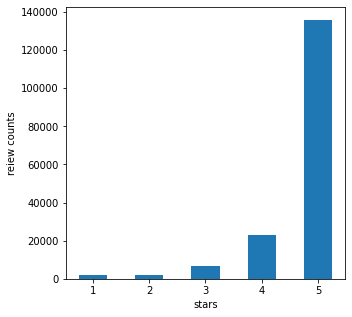

In [7]:
ax = full_df.overall.hist(grid=False, bins=np.arange(0.75,5.75,0.5),figsize=(5,5))

ax.set_xlabel("stars")
ax.set_ylabel("reiew counts")

Distribution of reviews per product

In [8]:
reviews_per_asin = full_df.asin.value_counts()
reviews_per_asin

B00CZF8B68    574
B00BWGHIHY    316
B00136J7ZE    294
B00EH49FRE    283
B00136NUG6    262
             ... 
B000W1S2WU      1
B00125MGQI      1
B001QET6G8      1
B001664ADA      1
B00138APMQ      1
Name: asin, Length: 11797, dtype: int64

reviews product-counts
5      2072
6      1506
7      1050
8       824
9       684
       ... 
146       1
147       1
148       1
152       1
574       1
Name: asin, Length: 163, dtype: int64


Text(0, 0.5, 'product counts')

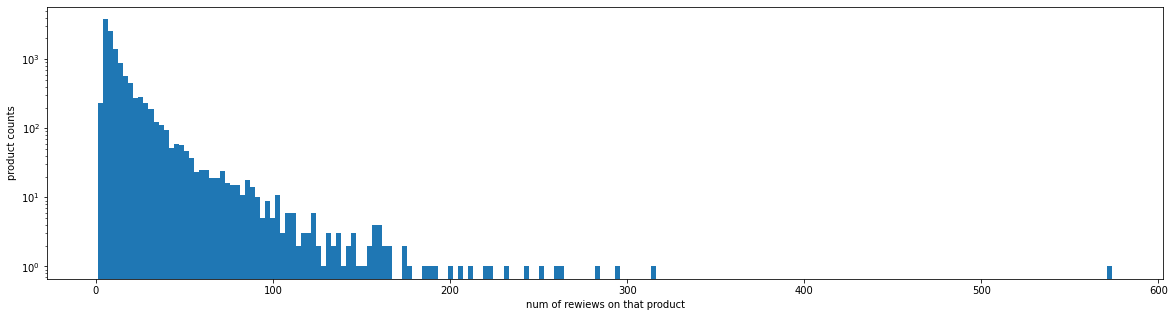

In [9]:
print("reviews product-counts")
print(reviews_per_asin.value_counts())

ax = reviews_per_asin.hist(log=True,grid=False,bins=200,figsize=(20,5))
ax.set_xlabel("num of rewiews on that product")
ax.set_ylabel("product counts")

Distribution of reviews per user

In [10]:
reviews_per_user = full_df.reviewerID.value_counts()
reviews_per_user

A3W4D8XOGLWUN5    791
A2H3JURQZOHVMB    314
A36EDWL4F3AASU    223
A165P3MOJV3OVZ    219
AVKHYC2D7MD56     214
                 ... 
A2VWLNEBMW4ITQ      2
A2M4D98UYXMUZE      2
A518S7KT78N51       2
A25HR6FTWBQ2NZ      1
A70WPHE33U5B        1
Name: reviewerID, Length: 16566, dtype: int64

reviews user-counts
5      4559
6      2798
7      1927
8      1288
9       974
       ... 
101       1
102       1
314       1
106       1
791       1
Name: reviewerID, Length: 125, dtype: int64


Text(0, 0.5, 'user counts')

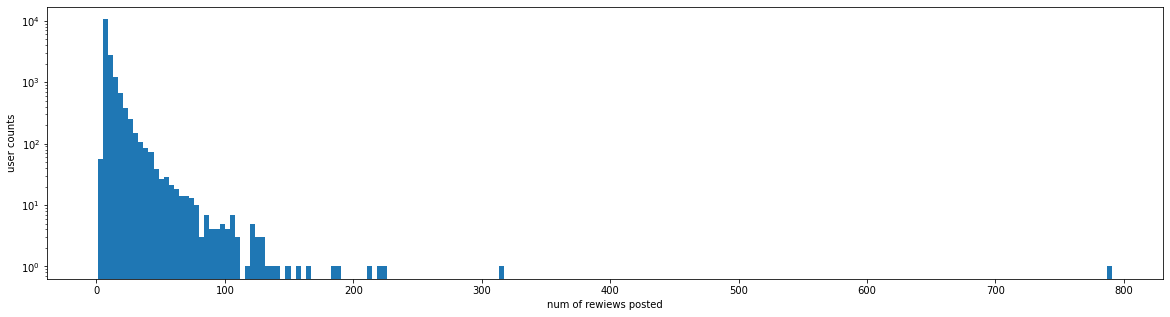

In [11]:
print("reviews user-counts")
print(reviews_per_user.value_counts())

ax = reviews_per_user.hist(log=True,grid=False,bins=200,figsize=(20,5))
ax.set_xlabel("num of rewiews posted")
ax.set_ylabel("user counts")


Shape of the dataset: (169781, 12)


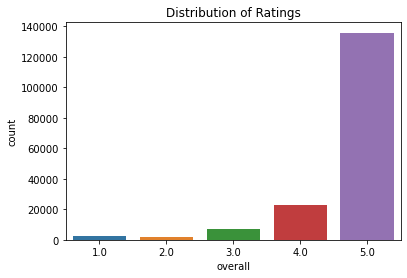

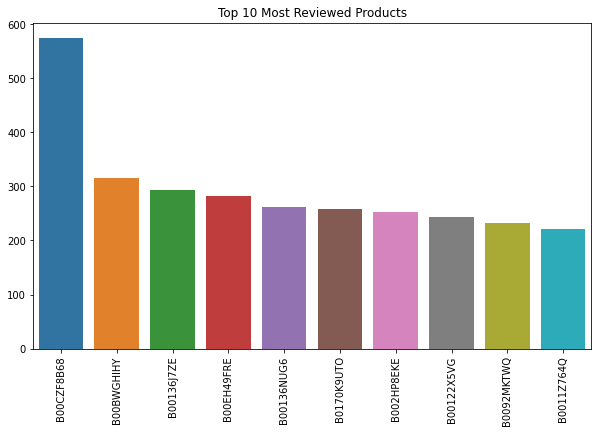

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check the shape of the dataset
print("Shape of the dataset:", full_df.shape)

# Check the distribution of ratings
sns.countplot(x='overall', data=full_df)
plt.title("Distribution of Ratings")
plt.show()

# Check the top 10 most reviewed products
top_products = full_df['asin'].value_counts().nlargest(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title("Top 10 Most Reviewed Products")
plt.xticks(rotation=90)
plt.show()

# 2. Text basic pre-processing

based on the value of “rating of the product”:<br/> i. Ratings 4,5: Positive <br/>ii. Rating 3: Neutral <br/>iii. Ratings 1,2: Negative


In [13]:
full_df['Sentiment'] = np.where((full_df['overall'] > 3), 'Positive', 
                          np.where((full_df['overall'] < 3), 'Negative', 'Neutral'))
full_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Sentiment
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN,Positive
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN,Positive
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN,Positive
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN,Positive
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN,Positive


In [14]:
full_df['Sentiment'].value_counts() 

Positive    158985
Neutral       6792
Negative      4004
Name: Sentiment, dtype: int64

## columns selection

In [15]:
full_df['verified'].value_counts()

True     148944
False     20837
Name: verified, dtype: int64

In [16]:
#full_df.info()

In [17]:
cols = ['reviewText','summary']
full_df['NewReview'] = full_df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
full_df['NewReview'] = full_df['NewReview'].astype(str)

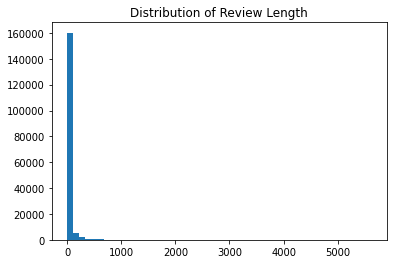

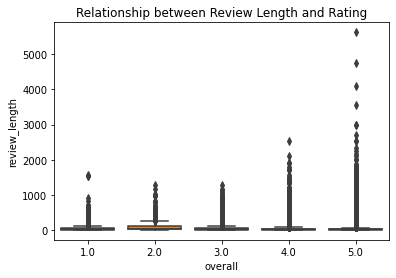

In [18]:
# Check the length of reviews
full_df['review_length'] = full_df['NewReview'].apply(lambda x: len(x.split()))
plt.hist(full_df['review_length'], bins=50)
plt.title("Distribution of Review Length")
plt.show()

# Check the relationship between review length and rating
sns.boxplot(x='overall', y='review_length', data=full_df)
plt.title("Relationship between Review Length and Rating")
plt.show()

In [19]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         169781 non-null  float64
 1   vote            7611 non-null    object 
 2   verified        169781 non-null  bool   
 3   reviewTime      169781 non-null  object 
 4   reviewerID      169781 non-null  object 
 5   asin            169781 non-null  object 
 6   style           157989 non-null  object 
 7   reviewerName    169776 non-null  object 
 8   reviewText      169623 non-null  object 
 9   summary         169745 non-null  object 
 10  unixReviewTime  169781 non-null  int64  
 11  image           182 non-null     object 
 12  Sentiment       169781 non-null  object 
 13  NewReview       169781 non-null  object 
 14  review_length   169781 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(11)
memory usage: 18.3+ MB


In [20]:
#reviewerID will be useful later to see if they are outliers or not
music_review_df = full_df.drop(columns=['vote','reviewerID','image','reviewTime','reviewerID','style','reviewerName','unixReviewTime','reviewText','summary'])

In [21]:
music_review_df.head(2)

,overall,verified,asin,Sentiment,NewReview,review_length
0,5.0,True,3426958910,Positive,"This is awesome to listen to, A must-have for ...",25
1,5.0,True,3426958910,Positive,bien Five Stars,3


In [22]:
music_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   overall        169781 non-null  float64
 1   verified       169781 non-null  bool   
 2   asin           169781 non-null  object 
 3   Sentiment      169781 non-null  object 
 4   NewReview      169781 non-null  object 
 5   review_length  169781 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 6.6+ MB


## sampling 

In [23]:
n_samples = 1000 # @param {type:"integer"}

#Getting the reviews from the dataset
sample_df=music_review_df.sample(n = n_samples)
# reviews = [str(review) for review in sample_df.NewReview.values] # moved



In [24]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1575 to 68158
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   overall        1000 non-null   float64
 1   verified       1000 non-null   bool   
 2   asin           1000 non-null   object 
 3   Sentiment      1000 non-null   object 
 4   NewReview      1000 non-null   object 
 5   review_length  1000 non-null   int64  
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 47.9+ KB


In [25]:
sample_df.head()

,overall,verified,asin,Sentiment,NewReview,review_length
1575,5.0,True,B000T027SO,Positive,Love this song! Five Stars,5
117035,5.0,True,B019A71124,Positive,Vince has his own sound and the music producer...,53
113560,5.0,True,B011JBUZXK,Positive,Awesome song! Five Stars,4
120630,5.0,True,B000S3BNY6,Positive,Fun group. Five Stars,4
93593,5.0,True,B00FX8F6VM,Positive,Love this Katy Perry song! Five Stars,7


In [26]:

reviews_raw = [str(review) for review in sample_df.NewReview.values]

# 3. Text representation (approaches in course module 2)

## Tokenisation, Lemmatization, Stemming, pos, entities

In [27]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Convert text to lowercase
sample_df['NewReview'] = sample_df['NewReview'].str.lower()

# Remove URLs
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: re.sub(r'http\S+', '', x))

# Remove HTML tags
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: re.sub(r'<.*?>', '', x))

# Remove punctuation
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [28]:

reviews = [str(review) for review in sample_df.NewReview.values]


In [29]:
# Tokenize the text
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: word_tokenize(x))

# Remove stopwords and perform stemming
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: [porter.stem(word) for word in x if word not in stop_words])

# Join the stemmed words back into a single string
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: ' '.join(x))


In [30]:
#Tokenisation
tokens = [[token.text for token in nlp(sentence)] for sentence in reviews]

#Lemmatization
lemmas = [[token.lemma_ if token.lemma_ != "-PRON-" else token.lower_ for token in nlp(sentence)] for sentence in reviews]

#Stemming
stems = [[stemmer.stem(token) for token in sentence] for sentence in tokens]

#Getting pos
pos = [nltk.pos_tag(token) for token in tokens]

#Getting entities
entities = [[[ent.text, ent.label_] for ent in nlp(sentence).ents] for sentence in reviews] 

In [31]:
#Most common people
people = [person[0] for person in [item for sublist in entities for item in sublist if item[1]=='PERSON']]
print('5 most common people: ', Counter(people).most_common(10))

#Most common music
music = [person[0] for person in [item for sublist in entities for item in sublist if item[1]=='WORK_OF_ART']]
print('5 most common work of art: ', Counter(music).most_common(10))

5 most common people:  [('michael jackson', 8), ('jordin', 7), ('ross', 4), ('paul mccartney', 4), ('katy perry', 3), ('elton johns', 3), ('katy', 3), ('god', 3), ('lou gherigs', 2), ('shawn colvin', 2)]
5 most common work of art:  []


In [32]:
#Taking the stems or the lemmas 
ptext = [' '.join(word) for word in lemmas]

#Converting to lowercase
ptext = [review.lower() for review in ptext]

#Removing numbers
ptext = [re.sub(r'\d+', '', review) for review in ptext]

#Removing punctuation
ptext = [re.sub(r'[^\w\s]',' ',review) for review in ptext]
ptext = [re.sub(' +', ' ', review) for review in ptext]
ptext = [re.sub('_', '', review) for review in ptext]

#Removing leading and trailing whitespaces
ptext = [review.strip() for review in ptext]

#Removing stopwords
ptext = [' '.join([word for word in review.split() if word not in stop_words]) for review in ptext]

In [35]:
frame = {'Original': reviews_raw, 
        'After Proprocessing': ptext}

pd.DataFrame.from_dict(frame)


,Original,After Proprocessing
0,Love this song! Five Stars,love song five star
1,Vince has his own sound and the music producer...,vince sound music producer really bring good c...
2,Awesome song! Five Stars,awesome song five star
3,Fun group. Five Stars,fun group five star
4,Love this Katy Perry song! Five Stars,love katy perry song five star
...,...,...
995,This is a great song. The recording I download...,great song recording download perfect problem ...
996,I was blown away by this album; every song is ...,blow away album every song fantastic every son...
997,Toni Braxton and babyface are great duet team ...,toni braxton babyface great duet team love alb...
998,Interesting artist. I can understand why Prin...,interesting artist understand prince would int...


In [ ]:
#Number of words
print('Number of words:')

bef = len(re.findall(r'\w+', ' '.join(reviews)))
aft = len(re.findall(r'\w+', ' '.join(ptext)))

print('- Before preprocessing: ', bef )
print('- After preprocessing: ', aft )
print()

#Average review length
print('Average review length:')

bef_a = bef/n_samples
aft_a = aft/n_samples

print('- Before preprocessing: ', bef_a )
print('- After preprocessing: ', aft_a )
print()

#Punctuation
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
punct_b = 0
for i in sample_df:
    punct_b += count(i,set(string.punctuation))
punct_a = 0
for i in ptext:
    punct_a += count(i,set(string.punctuation))
    
print('Number of punctuation character:')
print('- Before preprocessing: ', punct_b)
print('- After preprocessing: ', punct_a)
print()


Number of words:
- Before preprocessing:  35633
- After preprocessing:  18824

Average review length:
- Before preprocessing:  35.633
- After preprocessing:  18.824

Number of punctuation character:
- Before preprocessing:  1
- After preprocessing:  0



## glove

In [ ]:
from keras.utils import get_file

dir1 = get_file(origin="https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/glove.6B.100d.zip.001?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q")
dir2 = get_file(origin="https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/glove.6B.100d.zip.002?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q")

dir1

'C:\\Users\\98936\\.keras\\datasets\\glove.6B.100d.zip.001'

In [ ]:
### for Colab!!! change path if not running in Colab 

!cat /root/.keras/datasets/glove.6B.100d.zip* > /root/.keras/datasets/glove.6B.100d.zip

!unzip  /root/.keras/datasets/glove.6B.100d.zip 

The system cannot find the path specified.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
EMBEDDING_DIM = 100 # @param {type:"integer"}

In [ ]:

# first, build index mapping words in the embeddings set
# to their embedding vector

embeddings_index = {}
#C:\Courses_cent\COMP 262\practical-nlp-master\Ch4\Glove6B
#with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf-8") as f:
with open("glove.6B.100d.txt", encoding ="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))

def get_embeddings(word):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        # words not found in embedding index will be all-zeros.
        embedding_vector = np.zeros(shape=(EMBEDDING_DIM, ))
    return embedding_vector

Found 400000 word vectors in Glove embeddings.


In [ ]:
embeded = [[get_embeddings(word) for word in review.split() ] for review in ptext]


In [ ]:
frame = {'Original': reviews, 
        'After embedding': embeded}

pd.DataFrame.from_dict(frame)


,Original,After embedding
0,good song music,"[[-0.030769, 0.11993, 0.53909, -0.43696, -0.73..."
1,old old old school classic cornelius brothers ...,"[[0.17187, 0.62628, 0.4375, -0.61145, -0.3596,..."
2,very cool song five stars,"[[-0.74587, -0.31105, 0.50803, -0.29089, -0.27..."
3,i was walking south down broadway heading towa...,"[[0.20725, 0.84365, -0.076531, 0.0071135, -0.1..."
4,exactly as advertised five stars,"[[-0.02193, 0.36404, 0.61416, 0.28065, -0.6479..."
...,...,...
995,another great song five stars,"[[-0.13669, 0.16266, 0.32851, -0.23838, 0.3763..."
996,excellent five stars,"[[-0.2816, 0.18427, -0.06755, 0.27694, -0.0667..."
997,good song five stars,"[[-0.030769, 0.11993, 0.53909, -0.43696, -0.73..."
998,great song by a great frankie valie and the fo...,"[[-0.013786, 0.38216, 0.53236, 0.15261, -0.296..."



# 4. Modeling 

## VADR sentiment

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
#!pip install --upgrade vaderSentiment
#nltk.download('sentiwordnet')
#nltk.download('omw-1.4')

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0 :
        result = 'Positive'
 
    elif sentiment_dict['compound'] < - 0.07 :
        result = 'negative'
 
    else :
        result = 'Neutral'
    return result, sentiment_dict

In [ ]:
sample_df['NewReview']

93542                                       good song music
10831     old old old school classic corneliu brother si...
10025                                   cool song five star
48940     walk south broadway head toward subway sing ju...
51583                            exactli advertis five star
                                ...                        
35746                            anoth great song five star
114892                                      excel five star
83447                                   good song five star
37476     great song great franki vali four season five ...
18157                     anoth one music collect five star
Name: NewReview, Length: 1000, dtype: object

In [ ]:
sample_df.reset_index(inplace=True)

In [ ]:
VADR_df = pd.DataFrame()
VADR_df['Sentiment'] = sample_df['Sentiment']
VADR_df['NewReview'] = sample_df['NewReview']
VADR_df['SentimentScores'] = sample_df['NewReview'].apply(lambda x: sentiment_scores(x))
VADR_df[['PredictedSentiment','SentimentDict']] = VADR_df['SentimentScores'].apply(lambda x: pd.Series([x[0], x[1]]))

In [ ]:
VADR_df.head(3)

,Sentiment,NewReview,SentimentScores,PredictedSentiment,SentimentDict
0,Positive,good song music,"(Positive, {'neg': 0.0, 'neu': 0.408, 'pos': 0...",Positive,"{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp..."
1,Positive,old old old school classic corneliu brother si...,"(Positive, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0...",Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Positive,cool song five star,"(Positive, {'neg': 0.0, 'neu': 0.566, 'pos': 0...",Positive,"{'neg': 0.0, 'neu': 0.566, 'pos': 0.434, 'comp..."


In [ ]:
VADR_df['SentimentScores'][10] , VADR_df['Sentiment'][10], VADR_df['NewReview'][10]

(('Positive', {'neg': 0.0, 'neu': 0.559, 'pos': 0.441, 'compound': 0.7845}),
 'Positive',
 'like peopl buy song ive alreadi heard like soyeah think good five star')

In [ ]:
# Define a function to compute the accuracy
def compute_accuracy(row):
    if row['PredictedSentiment'] == row['Sentiment']:
        return 1
    else:
        return 0

# Apply the function to each row and save the results to a new column
VADR_df['accuracy'] = VADR_df.apply(compute_accuracy, axis=1)

# Compute the overall accuracy
accuracy = VADR_df['accuracy'].sum() / len(sample_df)
print(f"Overall accuracy: {accuracy}")

Overall accuracy: 0.904


In [ ]:
#using 0 as the Neutral
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] > 0 :
        result = 'Positive'
 
    elif sentiment_dict['compound'] < 0 :
        result = 'negative'
 
    else :
        result = 'Neutral'
    return result, sentiment_dict

VADR_df2 = pd.DataFrame()
VADR_df2['Sentiment'] = sample_df['Sentiment']
VADR_df2['NewReview'] = sample_df['NewReview']
VADR_df2['SentimentScores'] = sample_df['NewReview'].apply(lambda x: sentiment_scores(x))
VADR_df2[['PredictedSentiment','SentimentDict']] = VADR_df2['SentimentScores'].apply(lambda x: pd.Series([x[0], x[1]]))

# Apply the function to each row and save the results to a new column
VADR_df2['accuracy'] = VADR_df2.apply(compute_accuracy, axis=1)

# Compute the overall accuracy
accuracy = VADR_df2['accuracy'].sum() / len(sample_df)
print(f"Overall accuracy: {accuracy}")

Overall accuracy: 0.796


## Text blob

In [ ]:
from textblob import TextBlob
#nltk.download('punkt')
#nltk.download('brown')

In [ ]:
music_sample_df = TextBlob(sample_df['NewReview'][0])

In [ ]:
#Parts of Speech
music_sample_df.tags

[('good', 'JJ'), ('song', 'NN'), ('music', 'NN')]

In [ ]:
music_sample_df.noun_phrases

WordList(['good song music'])

In [ ]:
music_sample_df.sentiment

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)

In [ ]:
music_sample_df.words

WordList(['good', 'song', 'music'])

In [ ]:
df_textblob = pd.DataFrame()

In [ ]:
df_textblob = pd.DataFrame()
df_textblob['Scores'] = sample_df['NewReview'].apply(lambda tweet: TextBlob(tweet).sentiment)
df_textblob['subjectivity'] = sample_df['NewReview'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)
df_textblob['polarity'] = sample_df['NewReview'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
df_textblob['Sentiment'] = sample_df['Sentiment']
df_textblob['NewReview'] = sample_df['NewReview']

In [ ]:
def sentiment_calc(score):
  if score >= 0:
    return 'Positive'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Negative'

df_textblob['TextBlobSentiment'] = df_textblob['polarity'].apply(sentiment_calc)

In [ ]:
df_textblob.head(3)

,Scores,subjectivity,polarity,Sentiment,NewReview,TextBlobSentiment
0,"(0.7, 0.6000000000000001)",0.600000,0.700000,Positive,good song music,Positive
1,"(0.21333333333333332, 0.3433333333333334)",0.343333,0.213333,Positive,old old old school classic corneliu brother si...,Positive
2,"(0.35, 0.65)",0.650000,0.350000,Positive,cool song five star,Positive


In [ ]:
# Define a function to compute the accuracy
def compute_accuracy(row):
    if row['TextBlobSentiment'] == row['Sentiment']:
        return 1
    else:
        return 0

# Apply the function to each row and save the results to a new column
df_textblob['accuracy'] = df_textblob.apply(compute_accuracy, axis=1)

# Compute the overall accuracy
accuracy = df_textblob['accuracy'].sum() / len(df_textblob)
print(f"Overall accuracy: {accuracy}")

Overall accuracy: 0.916


## Word Cloud

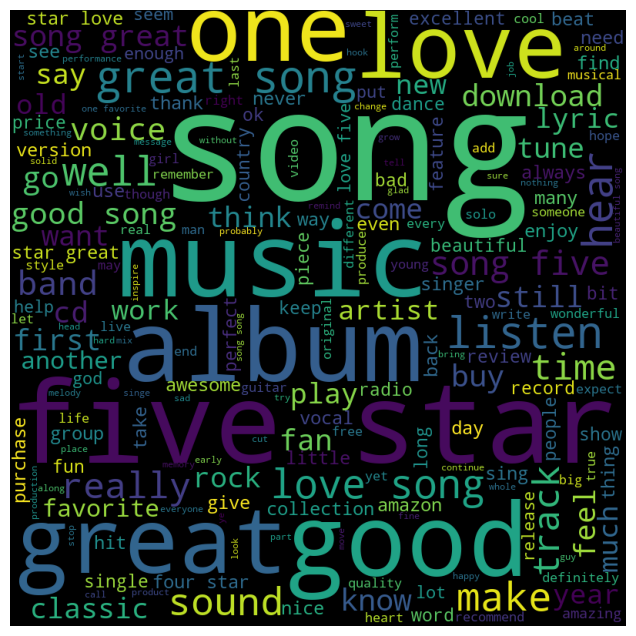

In [ ]:
#Code take from GFG to generate Word Cloud

comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in ptext:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

#Generate word cloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
#Plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
 
plt.show()